# Misc KBO planning calculations

This notebook contains calculations relevant to estimating the brightness distant KBO observations, specifically at high phase for rings detections via the phase curve. These are nominally planned with LORRI, but the question is whether 

### Initialize Python

In [1]:
import astropy.units as u
import astropy.constants as c
import math
import numpy as np
import matplotlib.pyplot as plt
import pymiecoated # Mie scattering library

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
                                    # Ignore warnings caused by pymiecoated's numpy usage 

import matplotlib                   # Set latex to use *not* CMR.
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'

r2d = 360 / (2*math.pi)             # Radians to degrees
d2r = 1/r2d

dist_pluto_ca_au   = 33             # NH heliocentric distance at Pluto flyby, in AU

### Look at simple cross-sectional area of Chariklo vs. its ring
We do a simple calculation: just look at the total cross-section of Chariklo, vs. the cross-section of its rings, at zero phase, assuming same albedo for each.

For comparison, we also do the same with MU69: take its cross-section, compared with the rings of Chariklo. (MU69 is much smaller than Chariklo, but here for an extreme case we assume it has Chariklo's ring system.)

In [2]:
r_chariklo = 315*u.km

r_ring = np.array([396, 405])*u.km
dr_ring = np.array([7, 3.5])*u.km
tau_ring = np.array([0.4, 0.06])

r_mu69 = 20*u.km

In [3]:
area_chariklo = math.pi * (r_chariklo**2)
area_mu69 = math.pi * (r_mu69**2)
area_ring = np.sum( 2 *math.pi * (r_ring * dr_ring) * tau_ring )

In [4]:
area_ring / area_chariklo

<Quantity 0.024063492063492065>

In [5]:
area_ring / area_mu69

<Quantity 5.96925>

In [6]:
area_ring.to('km^2')

<Quantity 7501.180778976349 km2>

### Conclusion

For Chariklo, the total surface area of the ring is only a few percent. For MU69, ring area > KBO area (for the assumptions made here.)

But this is at backscatter. As we move to forward-scatter, the KBO will get fainter, and the ring will likely get brighter. This would not be a subtle effect. It could totally dominate the phase curve. 

Below I calculate this in more detail.

## Detailed calculation of MVIC vs. LORRI for unresolved KBO observations

What we want here:
* Assume a v=20 KBO, at 140 deg phase. This is the worst case. Calculate DN/pixel/sec for this.
* Calculate the stray light in LORRI. Hal's table gives this in I/F, and we can convert this to DN/sec/pixel.
* One of these conversions uses unresolved. One uses resolved. So, we use RSOLAR and PSOLAR.

To convert to DN, we use standard LORRI RT equations:<br>
`V = -2.5 log`$_{10}$` S + PHOTZPT + CC + BC`<br>
     i.e.,<br>
`S = 10^((BC + CC + PHOTZPT - V) / 2.5)`<br>
* `V` = mag
* `PHOTZPT` = zero pount for LORRI = 18.94 (from Hal's paper)
* `CC` = Color Correction. Assume zero since reflected solar.
* `S` = Integrated net signal rate from target, in DN/sec
* `BC` = Aperture Correction. Assume zero.

For MVIC, there has not been a recommended value derived for `PHOTZPT`. However, Cathy & Carly suggested using the ETC to derive one. Assume:

* `V = 5`
* `SNR = 300`

Then ETC gives results

* `Fraction Saturated = 0.91` → 91,000 electrons. (Verified full-well assumption by looking in code on ixion.)
* `Exptime = 0.26 sec`

And we know

* `E_PER_DN_MVIC = 58.6`

So we can easily calculate `S = 5972 DN/sec`. 

This is the signal *in the brightest pixel*. But the total stellar signal (which is what I want) is spread over several pixels. For LORRI, about 1/3 of the light is in the central pixel [need to verify this -- it might be different for MVIC -- but this is based on my 'dummy check' below, which gets a factor of 3 discrepancy]. With this assumption, we have

`S = 5972 * 3 = 17916 DN/sec`.

We apply

`PHOTZPT = V + 2.5 log`$_{10}$`S`

and get

* `PHOTZPT_MVIC = 15.63`

I checked this with several different values of `SNR` and `V` and got similar results. 

### Define Photometric Constants for MVIC and LORRI

In [7]:
# Following are from Hal's e-mail to HBT, 7-Dec-2016

PHOTZPT_LORRI_1X1    = 18.76 # LORRI 1x1 Photometric z-point, as per Hal's email 7-Dec-2016
PHOTZPT_LORRI_4X4    = 18.91 # V = -2.5 log10(S/text) + PHOTZPT + CC - AC

RSOLAR_LORRI_1X1     = 221999.98 # Diffuse sensitivity. (DN/s/pixel) / (erg/cm2/s/A/sr)
RSOLAR_LORRI_4X4     = 3800640.0

# Following is calculated by HBT, from MVIC Exposure Time Calculator
# 'MVIC' is assumed to be Pan Frame always.

PHOTZPT_MVIC     = 15.63 # My rough estimate from MVIC ETC (v=5, SNR=300 → 91000 e- → 91000/58.6 DN, in t=0.26 sec)

# Following is from MVIC pan frame FITS header. Hal says it should be revised downward by ~20%, but I am ingoring.

RSOLAR_MVIC  = 100190.64 # (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum 

# Following is from Cathy

E_PER_DN_MVIC = 58.6

# Following is from LORRI 4x4 header

E_PER_DN_LORRI_4X4 = 22

# Following are from Hal's LORRI writeup on the Wiki

F_SOLAR          = 176   # Solar flux at 1 AU, cgs units.

# Following are from Hal's email to HBT 14-Dec-2016. 
# "[AC]" is the aperture correction (in case the flux is not integrated over the entire stellar image; 
# a careful analysis of the flux versus aperture size for a bright star in the field can then be used 
# to determine the value of BC for the aperture selected for the photometry)." -- wiki

AC_LORRI_1X1 = 0.091 # 5-pixel radius circular aperture 
AC_LORRI_4X4 = 0.022 # 5-pixel radius circular aperture

## Set the LORRI mode
In general we use `4X4` for this observation. The `1X1` resolution is unnecessary, and just adds readnoise. Disadvantage of `4X4` is the shorter `EXPTIME` for saturation.

In [8]:
mode_lorri = '4X4'           # Set this to either 4X4 or 1X1.

## Now look at stray light and the signal from KBO and its ring

Conventions to adopt here:
* All angles are the phase angle $\phi$. 180 = forward; 0 = backscatter.
* Scattering angle is $\alpha$, but I try not to use it. My papers also use $\theta$ to be scattering angle.
* Hal's plot of stray light is *opposite* to this ('Angle from sun'). I don't use his convention.
* Keep all angles internally in radians

### Define the LORRI stray light function

In [9]:
IoF_stray_lorri_arr = np.transpose(np.array([
                        [0.1, 100], # Take the raw data from Hal's plot. Angle from sun in Deg, and I/F.
                        [1, 10],    # I/F values are indep of distance.
                        [2, 1],
                        [15, 1.5e-2],
                        [20, 2e-3],
                        [25, 1e-3],
                        [30, 8e-4],
                        [50, 1e-4],
                        [60, 3e-5],
                        [75,1e-5]]))

### Flip this around so it's a function of phase angle (not scattering angle).

In [10]:
angle_stray           = IoF_stray_lorri_arr[0,:]
phi_stray_lorri       = (180 - angle_stray) * d2r # Phase angle, in radians
IoF_stray_lorri       = IoF_stray_lorri_arr[1,:]

# Convert Hal's chart values from I/F, to DN, using normalization constant on that chart.

S_stray_lorri_pluto_1x1 = IoF_stray_lorri * (10 / 8e-4)     # DN/sec/pixel [blue dashed line in Hal's slide]
                                                            # DN/sec is for Pluto distance.
                                                            # For other distances, multiply by (33/dist_au)**2

# Scale from DN/s for 1x1, to 4x4

S_stray_lorri_pluto_4x4 = S_stray_lorri_pluto_1x1 * 16

# Now do a test conversion: convert this from I/F to DN/sec using RT eq's.

S_stray_lorri_pluto_test = RSOLAR_LORRI_1X1 = IoF_stray_lorri * (1/math.pi) * F_SOLAR / dist_pluto_ca_au**2

### Set photometric parameters based LORRI binning mode

In [11]:
if (mode_lorri == '1X1'):
    RSOLAR_LORRI        = RSOLAR_LORRI_1X1
    PHOTZPT_LORRI       = PHOTZPT_LORRI_1X1
    S_stray_lorri_pluto = S_stray_lorri_pluto_1x1
    
if (mode_lorri == '4X4'):
    RSOLAR_LORRI        = RSOLAR_LORRI_4X4
    PHOTZPT_LORRI       = PHOTZPT_LORRI_4X4
    S_stray_lorri_pluto = S_stray_lorri_pluto_4x4

### Do a quick validation of the LORRI brightness vs. the ETC. ETC calculates 0.12 DN/sec for V=20 target with solar spectrum.

Also, Hal: "As a check, when you express the signal in e/s, the ratio of LORRI 4x4 to MVIC should be ~16 because that’s the throughput (A*Omega) difference between the two instruments."



In [12]:
V_test = 15  # Test magnitude
print("LORRI, {}, V={} → S = {:.4f} DN/sec".format('1X1', V_test, 10**((PHOTZPT_LORRI_1X1 - V_test)/2.5))) 
print("LORRI, {}, V={} → S = {:.4f} DN/sec".format('4X4', V_test, 10**((PHOTZPT_LORRI_4X4 - V_test)/2.5))) 
print("LORRI, {}, V={} → S = {:.4f} e /sec".format('4X4', V_test, 10**((PHOTZPT_LORRI_4X4 - V_test)/2.5)*
                                                   E_PER_DN_LORRI_4X4)) 
print("MVIC,       V={} → S = {:.4f} DN/sec".format(V_test, 10**((PHOTZPT_MVIC  - V_test)/2.5)))
print("MVIC,       V={} → S = {:.4f} e /sec".format(V_test, 10**((PHOTZPT_MVIC  - V_test)/2.5) *
                                                    E_PER_DN_MVIC))

print("DN/s and e/s are total fluxes, integrated across the PSF.")
print("Fluxes in ETC are of the brightest pixel only, so are less than these values here.")

LORRI, 1X1, V=15 → S = 31.9154 DN/sec
LORRI, 4X4, V=15 → S = 36.6438 DN/sec
LORRI, 4X4, V=15 → S = 806.1627 e /sec
MVIC,       V=15 → S = 1.7865 DN/sec
MVIC,       V=15 → S = 104.6882 e /sec
DN/s and e/s are total fluxes, integrated across the PSF.
Fluxes in ETC are of the brightest pixel only, so are less than these values here.


NB: ETC calculates a signal 3x fainter for LORRI than I calculate here. This is because ETC calculates flux only in the central (brightest) pixel, while the eq above gives total DN, integrated over the PSF. ETC is useful for avoiding saturation, but for photometry, we will sum flux across the FOV.

### Define the MVIC stray light function

In [13]:
IoF_stray_mvic_arr = np.transpose(np.array([
                    [13, 5e-3],    # https://www.spaceops.swri.org/nh/wiki/images/1/14/Pan2preview.pdf - ACO2
                    [21, 1.3e-3],  # https://www.spaceops.swri.org/nh/wiki/images/2/25/Pan1preview.pdf - ACO1
                    [26, 1.1e-3],
                    [30, 8e-4],
                    [40, 1.2e-4],
                    [46, 3e-5],
                    [51, 3e-5],
                    [56, 3e-5],
                    [61, 3e-5],
                    [66, 3e-5],
                    [71, 3e-5],
                    [76, 3e-5],
                    [81, 3e-5],
                    [86, 3e-5],
                    [91, 3e-5]]))

angle_stray        = IoF_stray_mvic_arr[0,:]
phi_stray_mvic     = (180 - angle_stray) * d2r # Phase angle, in radians
IoF_stray_mvic     = IoF_stray_mvic_arr[1,:]

# Convert MVIC stray from I/F to DN/sec/pix at Pluto's distance. 
# Use the MVIC photometric equations (I/F = pi I R^2 / F_SOLAR).

S_stray_mvic_pluto = RSOLAR_MVIC * IoF_stray_mvic * (1/math.pi) * F_SOLAR / dist_pluto_ca_au**2

### Make a test plot of I/F (distance-independent). This can be compared directly to Hal's plot.

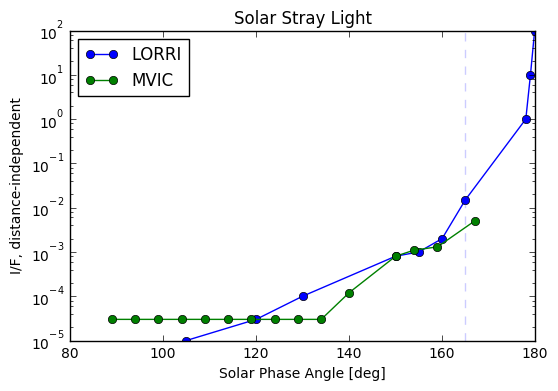

In [14]:
plt.plot(phi_stray_lorri*r2d, IoF_stray_lorri, marker = 'o', label = 'LORRI')
plt.plot(phi_stray_mvic*r2d, IoF_stray_mvic,   marker = 'o', label = 'MVIC')
plt.yscale('log')
plt.xlabel('Solar Phase Angle [deg]')
plt.ylabel('I/F, distance-independent')
plt.title('Solar Stray Light')
plt.legend(loc = 'upper left')
# plt.axhline(1,linestyle='--', alpha=0.2)    # 1 DN/sec
plt.axvline(165,linestyle='--', alpha=0.2)  # Outbound asymptote
plt.show()

Surprisingly, I/F for LORRI and MVIC are quite similar. I've overlain the raw plots (that these data are from) and that confirms this.

This is at odds with our general understanding, that MVIC has better stray light rejection. Two possibililties:

1. These data (MVIC is from ACO-1) were taken at a rotation angle at which MVIC has poor rejection. There is a broad range of angles like this. I can confirm this by looking at the actual observations, but that will just take some time.

2. Perhaps Tod's stray light algorithms just work better on MVIC than LORRI. I have been comparing the post-processed MVIC and LORRI images, where is where I come to the conclusion that MVIC is 10-30x better than LORRI. (The difference between 10 and 30 is probably that 10 is Tod's old algorithm, and 30 is his new one, which he didn't apply to all of the mosaics yet.)

### Make another stray light plot, but in DN/sec/pix

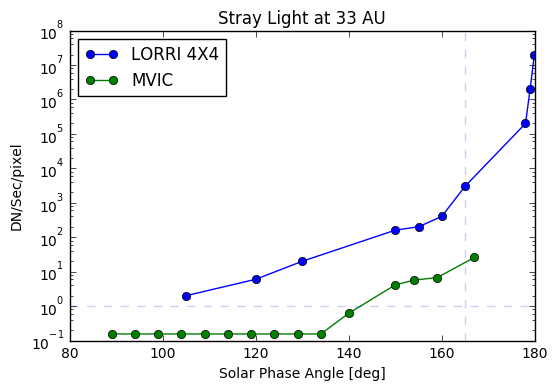

In [15]:
plt.plot(phi_stray_lorri*r2d, S_stray_lorri_pluto, marker = 'o', label = 'LORRI ' + mode_lorri)
plt.plot(phi_stray_mvic*r2d, S_stray_mvic_pluto, marker = 'o', label = 'MVIC')
plt.yscale('log')
plt.xlabel('Solar Phase Angle [deg]')
plt.ylabel('DN/Sec/pixel')
plt.title('Stray Light at 33 AU')
plt.axhline(1,linestyle='--', alpha=0.2)    # 1 DN/sec
plt.axvline(165,linestyle='--', alpha=0.2)  # Outbound asymptote
plt.legend(loc = 'upper left')
plt.show()

### Define a Lambertian phase function

In [16]:
def phase_function_lambert(phi):
    '''Returns phase function, given phase angle phi in radians. '''
    return (8/(3*math.pi) * (np.sin(phi) + (math.pi - phi)*np.cos(phi) ))

### Define a Mie phase function

In [17]:
def phase_function_mie(x, n_refract, phi):
    '''Returns phase function, given phase angle phi in radians.'''
    p11 = [] # List for the output array (n_x  X  n_angles)

    alpha = math.pi - phi                               # alpha is scattering angle. Phi is phase angle.
    
    for x_i in x:
        mie    = pymiecoated.Mie(x=x_i,m=n_refract)
        p11_i  = []     # Create the output arrays for each individual angular phase function

        for a in alpha: # Loop over angle
            S12 = mie.S12(np.cos(a))                    # Get the Mie coefficient using pymiecoated library
            p11_i.append(np.abs(S12[0]**2 + S12[1]**2)) # Compute the amplitude at each angle

        p11_i = np.array(p11_i)                         # Save the result
        p11.append(p11_i)

    p11_arr = np.array(p11)
    p11_out = np.sum(p11_arr,0)                         # Average all the phase functions together into one

    dalpha = abs(alpha[1] - alpha[0]) 
    p11 = p11_out
    p11 = p11 * 2 / (np.sum(p11 * np.sin(alpha) * dalpha)) # Normalize the phase function integral to 2

    return p11

### Set  up parameters, and do some calculations to generate a phase curve for a solid body and a ring

In [18]:
num_phi   = 100                                      # Number of angles in our phase function
phi       = np.array(range(num_phi))*math.pi/num_phi # Phase angles
n_refract = complex(1.5, 1e-2)                       # Ring refractive index. Not really critical what we choose.
x         = np.array([40, 50, 52, 55, 60])           # Ring is a mean of all of these X values. Arbitrary.

p11_lambert    = phase_function_lambert(phi)                         # Solid body, lambertian curve 
p11_mie        = phase_function_mie(x, n_refract, phi)               # 'Normal' dusty rings

### Enter assumptions about KBO size, distance, and ring area

In [19]:
V               = 15  # Magnitude of KBO. Typical magnitudes, as seen from NH, are 15-20.
dist_kbo_au     = 35  # Orbital distance, in AU. KBO flybys are mostly 2017 - 2018, at distances 37 .. 42 AU.
ratio_ring_body = 1   # Brightness ratio, at backscatter. (ie, area ratio of rings : central_body, assuming same albedo)

### Do photometric calculations

In [20]:
# Create the phase function for the KBO body.
# S = count rate, in DN/sec

# First calculate maximum count rate, at backscatter

S_kbo_lorri   = 10**((PHOTZPT_LORRI - V)/2.5)           # Calculate LORRI DN/sec for unresolved source of a given mag
S_kbo_mvic    = 10**((PHOTZPT_MVIC - V)/2.5)            # MVIC pan frame DN/sec

# Convolve this with the lambertian phase fuction. Normalize the latter to be 1 at backscatter.

S_kbo_lambert_mvic  = p11_lambert * (S_kbo_mvic  / p11_lambert[0])
S_kbo_lambert_lorri = p11_lambert * (S_kbo_lorri / p11_lambert[0])

# Create the phase function for the KBO rings, and normalize similarly.

S_kbo_mie_lorri     = p11_mie * (S_kbo_lorri / p11_mie[0]) * ratio_ring_body
S_kbo_mie_mvic      = p11_mie * (S_kbo_mvic  / p11_mie[0]) * ratio_ring_body

# Sum the KBO and Rings phase functions, to get the Ringed phase function

S_kbo_ringed_lorri = S_kbo_lambert_lorri + S_kbo_mie_lorri
S_kbo_ringed_mvic  = S_kbo_lambert_mvic  + S_kbo_mie_mvic

### And make a plot of the two phase curves, plus the stray light curve

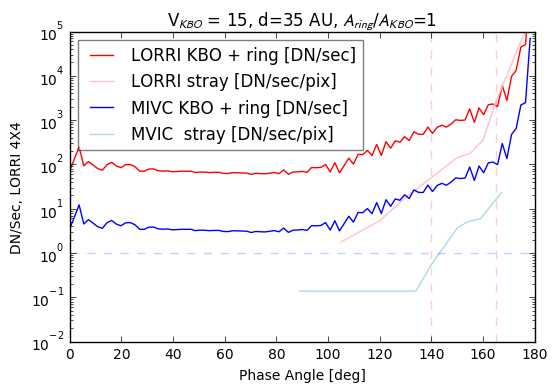

In [21]:
# plt.plot(phi*r2d,       S_kbo_lambert,       label = 'KBO Body [DN/sec]')
# plt.plot(phi*r2d,       S_kbo_mie,           label = 'KBO Rings [DN/sec]')

plt.plot(phi*r2d,       S_kbo_ringed_lorri, 
         color = 'red', label = 'LORRI KBO + ring [DN/sec]' )

plt.plot(phi_stray_lorri*r2d, S_stray_lorri_pluto * (dist_pluto_ca_au/dist_kbo_au)**2, 
         color = 'pink',
         label = 'LORRI stray [DN/sec/pix]')

plt.plot(phi*r2d,       S_kbo_ringed_mvic, 
         color = 'blue', label = 'MIVC KBO + ring [DN/sec]' )

plt.plot(phi_stray_mvic*r2d, S_stray_mvic_pluto  * (dist_pluto_ca_au/dist_kbo_au)**2, 
         color = 'lightblue',
         label = 'MVIC  stray [DN/sec/pix]')

plt.axhline(y=1,linestyle='--', alpha=0.2)                  # Horizontal dashed line at 1 DN/sec
plt.axvline(x=165, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at departure asymptote
plt.axvline(x=140, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at 140 deg (end of KBO 2016 obs)

plt.ylabel('DN/Sec, LORRI ' + mode_lorri)
plt.xlabel('Phase Angle [deg]')
plt.yscale('log')
plt.legend(framealpha=0.5, loc = 'upper left')
plt.ylim((1e-2, 1e5))
plt.title('V$_{{KBO}}$ = {}, d={} AU, $A_{{ring}}$/$A_{{KBO}}$={}'.format(V, dist_kbo_au, ratio_ring_body))

## Conclusions: 
I've done a bunch of cases. In all of them, LORRI stray light really dominates past 140 deg.

I don't have a quantitative measurement here for MVIC stray light. But on rings obs on DOY 2015-202 and 2015-305, the post-reduction stray light in LORRI was 10-100x worse (in units of I/F) than MVIC (that is, after Tod removed stray light from both). Tod's algorithm probably reduced stray light by 10x, at 165 deg.

---

### Look at size of KBO vs. MVIC and LORRI pixel sizes. How resolved are they?

In [22]:
scale_lorri_1x1 = 0.3*d2r / 1024
scale_lorri_4x4 = scale_lorri_1x1 * 4
scale_mvic      = 5.7*d2r / 5024

scale_kbo_rings = 2 * 400*u.km / (0.5*u.AU) # Use diameter, not radius
scale_kbo_small = 2 * 16*u.km  / (1*u.AU)

### Compute size of a ringed KBO, in LORRI 1x1 pixels (ie, best case)

In [23]:
(scale_kbo_rings / scale_lorri_1x1).to('1')

<Quantity 2.0916831840582715>

### Compute size of a small, distant KBO, in MVIC pixels (ie, worst case)

In [24]:
(scale_kbo_rings / scale_mvic).to('1')

<Quantity 0.5401221379887312>

In [25]:
phase_function_lambert(0)

2.6666666666666665

In [34]:
phase_function_lambert(168.2*d2r) / phase_function_lambert(0)

0.00092291950130663912